# Answers to Moz Sr Data Scientist interview question

- Applicant: Yao You
- date: 2020-Aug-21

## main points

Here we model the amount a customer pays Moz in the prior month using the session time the user spent with Moz product, the industry and geography of the customer, and the type of browser used. Analysis finds that:

- Customers in the US and Canada spends signifcantly more than others when all others are equal
- Customers tend to spend more when they spend more time with Moz product: customers spending less than around 150 seconds pay about the same; customer spending more money with more time than 150 seconds with a log-linear relationship
- Customers in marketing agencies spend more than the rest; only the customers without a clear industr designation spends much less than others
- Browser doesn't affect customer spending significantly

![feature_slope](figs/feature_slope.png)

![time_spent_vs_money_spent](figs/geography_impact.png)

Based on those observations we recommend:

- focus on developing for the US and Canada markets, especially for the marketing agencies
- analyze why other geography are performing worse than US and Canada, are there any thing different that we can learn from our offerings to the US and Canada markets that we can apply to other countries to improve the revenue?
- gather data to fill the blanks in the industry type so we can find out if there is an industry we are not addressing properly that causes less than average revenue

We have created a model that predicts the revenue from a customer using those aformentioned features with an $R^2$ score of 0.992. The model is serialized in the folder with the name `model.pkl`.

In [2]:
!pip3 install -r requirements.txt

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
import os

## load data

In [4]:
os.listdir('.')

['requirements.txt',
 'data',
 '.gitignore',
 'Moz Interview.ipynb',
 'venv',
 '.git',
 '.ipynb_checkpoints']

In [5]:
train_data = pd.read_csv('data/moz_customer_data_train.csv', sep='|')
test_data = pd.read_csv('data/moz_customer_data_test.csv', sep='|')

## explore data

Generally we examine data with the following steps:

- random sample to get an idea what they look like
- descriptive statistics for both numerical and categorical data, especially the distribution of the data to spot any outliers or log normal like distribution in the target variable (that can benefit from transformation)
- count nulls
- count uniques to make sure id is unique

First we use the module `pandas_profiling` for some quick summaries of the dataset.

In [45]:
ProfileReport(train_data)

In [46]:
ProfileReport(test_data)

The reports show that train and test are comparabe, confirming that we can train a model on train data and expect it to perform similarily on the test data.

The report shows that the variable `session_time_prior_month_seconds` has a long tail distribution so we may consider transform it if we were to use linear regression. Tree based model are not going to be sensitive to the distribution, however. 

Next, we dig deeper into the categorical variables to see its distribution. We convert them into categorical data types first then run some descriptive statistics on them.

In [6]:
train_data = train_data.set_index('id')
test_data = test_data.set_index('id')
target = 'prior_month_paid'

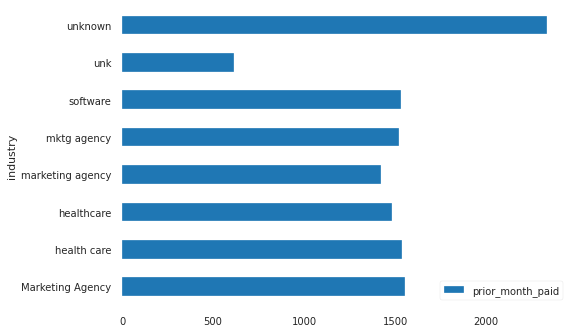

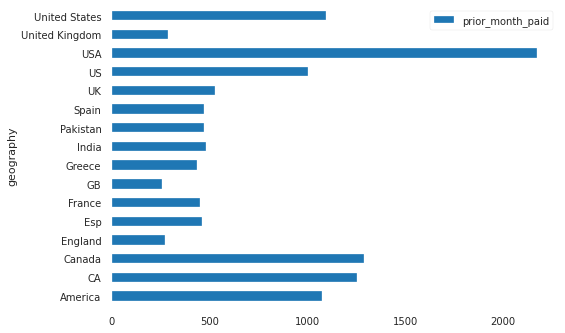

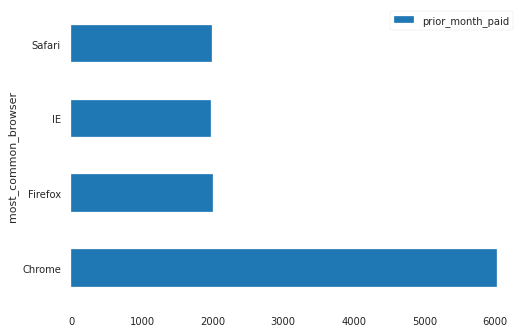

In [7]:
cats = ['industry', 'geography', 'most_common_browser']
for cat in cats:
    train_data[cat] = train_data[cat].fillna('unknown')
    test_data[cat] = test_data[cat].fillna('unknown')
    test_data[[cat, target]].groupby(cat).count().plot(kind='barh')

The bar charts above shows that there are duplicated labels like `US` and `America`. We will consolidate those labels.

In [8]:
train_data['industry'].unique()

array(['unknown', 'healthcare', 'health care', 'marketing agency',
       'Marketing Agency', 'software', 'unk', 'mktg agency'], dtype=object)

In [9]:
label_translator = {
    'mktg agency': 'marketing agency',
    'Marketing Agency': 'marketing agency',
    'unk': 'unknown',
    'health care': 'healthcare'
}
train_data.loc[:, 'industry'] = train_data['industry'].replace(label_translator)
test_data.loc[:, 'industry'] = test_data['industry'].replace(label_translator)

print("transformed labels in train: {}".format(
    ', '.join(train_data['industry'].unique().tolist())))
print("transformed labels in test: {}".format(
    ', '.join(test_data['industry'].unique().tolist())))

transformed labels in train: unknown, healthcare, marketing agency, software
transformed labels in test: healthcare, unknown, marketing agency, software


In [10]:
train_data['geography'].unique().tolist()

['GB',
 'US',
 'Canada',
 'Greece',
 'USA',
 'CA',
 'America',
 'United States',
 'Esp',
 'UK',
 'India',
 'Pakistan',
 'United Kingdom',
 'England',
 'France',
 'Spain']

In [11]:
cat = 'geography'

# here I assumed that 'America' means 'USA'

label_translator = {
    'United Kingdom': 'UK',
    'GB': 'UK',
    'United States': 'USA',
    'US': 'USA',
    'CA': 'Canada',
    'America': 'USA',
    'Spain': 'Esp',
    'England': 'UK'
}
train_data.loc[:, cat] = train_data[cat].replace(label_translator)
test_data.loc[:, cat] = test_data[cat].replace(label_translator)

print("transformed labels in train: {}".format(
    ', '.join(train_data[cat].unique().tolist())))
print("transformed labels in test: {}".format(
    ', '.join(test_data[cat].unique().tolist())))

transformed labels in train: UK, USA, Canada, Greece, Esp, India, Pakistan, France
transformed labels in test: USA, UK, Esp, Greece, Canada, India, France, Pakistan


Much better

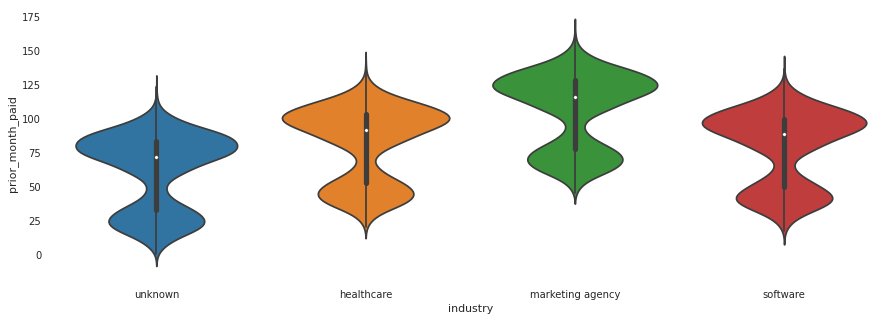

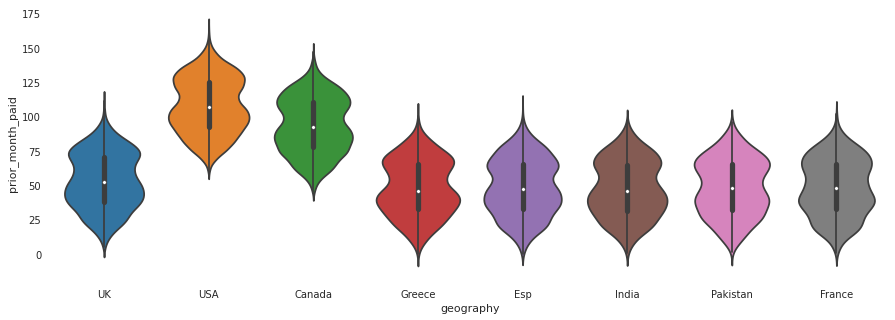

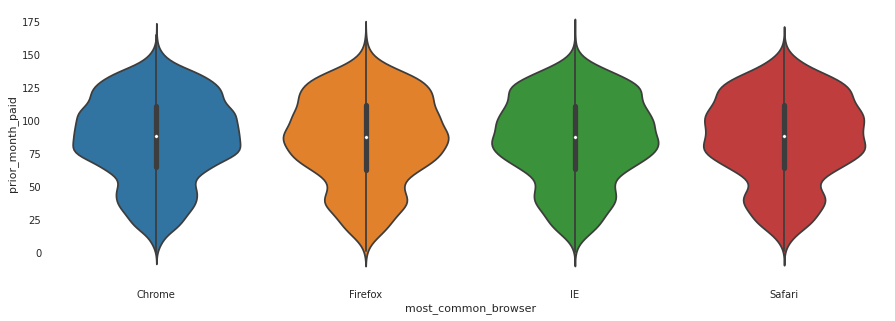

In [12]:
for cat in cats:
    plt.figure(figsize=(15, 5))
    sns.violinplot(train_data[cat], train_data[target])
    plt.show()

The voilin plots above show distribution of the target variable for a category, e.g., `chrome`. It shows that all categories have a relatively wide distribution of the target variable. 

So now we convert the categorical to codes and use log transform to transform the `session_time_prior_month_seconds`.

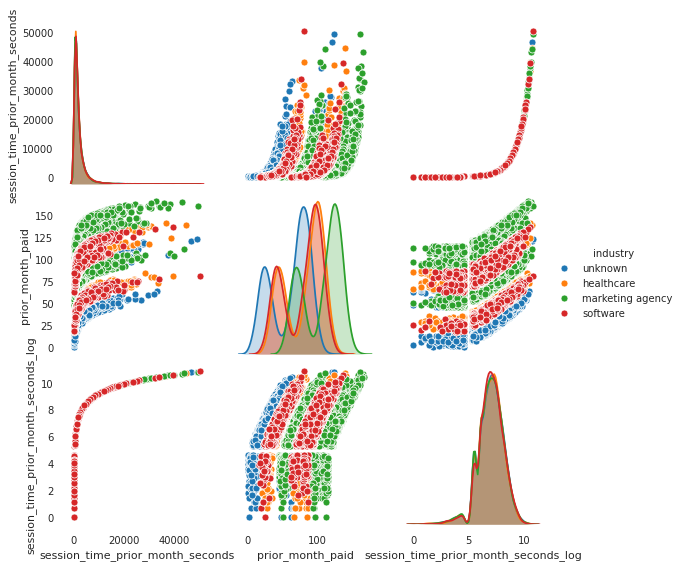

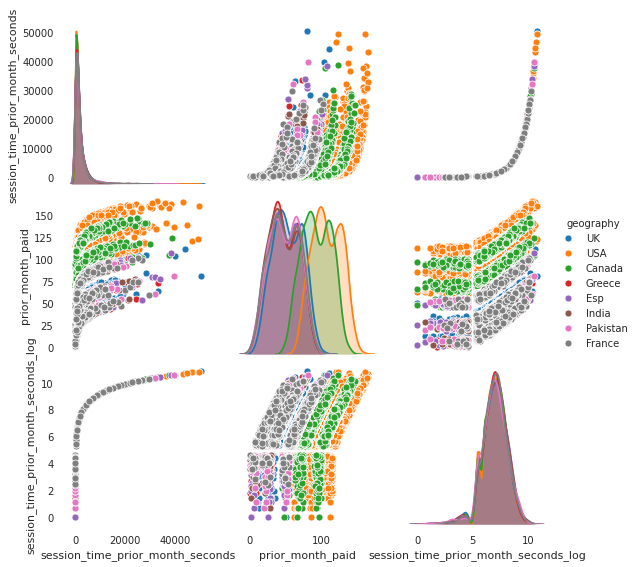

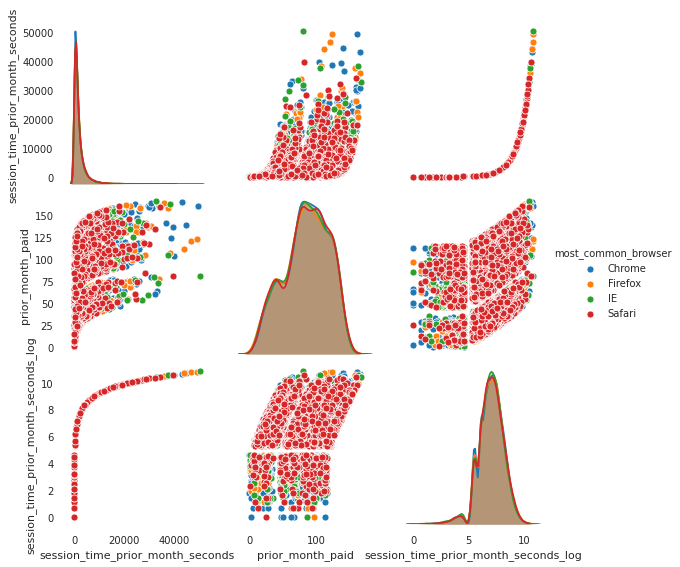

In [13]:
train_data['session_time_prior_month_seconds_log'] = np.log(
    train_data['session_time_prior_month_seconds']
)
test_data['session_time_prior_month_seconds_log'] = np.log(
    test_data['session_time_prior_month_seconds']
)
for cat in cats:
    sns.pairplot(train_data, hue=cat)
    plt.show()

From the above plots we can see that clearly the target `prior_month_paid` has log-linear relationships with the feature `session_time_prior_month_seconds` (linear trends on the log transformed feature). We also see that for time spent less than `exp(5)` there is no difference: i.e., the all generate the same amount of income for a given category combinations. We can help a linear model by making all session time less than `exp(5)` equal to `exp(5)`. We should also keep that number in mind. That is an almost magical threshold, where customer usage starts to positively impact revenue for Moz.

We also see that there is no obvious statistical trends between browser used and the target so this is likely not an important feature, and we will consider dropping it in linear models.

## Modeling

We will build a tree based model. The observations above is a perfect fit for the tree model because it contains unordered categorical variables and numerical variables. We could attempt to build a linear model for each combination of unique industry and geography but that tends to overfit the model. It is better to let the model learn that distinction from the data.

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

Here we transform the data further by:

- trim the values of the session time
- standardize session time

In [15]:
train_data['session_time_log_cutoff'] = np.maximum(
    5, train_data[['session_time_prior_month_seconds_log']]
)
scaler = StandardScaler().fit(train_data[['session_time_log_cutoff']])
train_data['session_time_std_log'] = scaler.transform(
    train_data[['session_time_log_cutoff']]
)
train_data_oh = pd.get_dummies(train_data)

test_data['session_time_log_cutoff'] = np.maximum(
    5, test_data[['session_time_prior_month_seconds_log']]
)
test_data['session_time_std_log'] = scaler.transform(
    test_data[['session_time_log_cutoff']]
)
test_data_oh = pd.get_dummies(test_data)


We first use __log transformed__ session time to build a ridge linear model (regularized linear model)

In [44]:
features = [col for col in train_data_oh if col not in [
    target,'session_time_prior_month_seconds', 
    'session_time_prior_month_seconds_log',
    'session_time_log_cutoff'
]]

train_x, train_y = train_data_oh[features], train_data_oh[target]
test_x, test_y = test_data_oh[features], test_data_oh[target]
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.2, random_state=42
)

In [45]:
print(f"training set has {len(features)} features: {', '.join(features)} and {len(train_x)} rows")

training set has 17 features: session_time_std_log, industry_healthcare, industry_marketing agency, industry_software, industry_unknown, geography_Canada, geography_Esp, geography_France, geography_Greece, geography_India, geography_Pakistan, geography_UK, geography_USA, most_common_browser_Chrome, most_common_browser_Firefox, most_common_browser_IE, most_common_browser_Safari and 38400 rows


In [46]:
ridge = RidgeCV().fit(train_x, train_y)

In [47]:
print(f"training score is {ridge.score(train_x, train_y)}")
print(f"validation score is {ridge.score(val_x, val_y)}")

training score is 0.9917376473262857
validation score is 0.9917449707011315


Here we use the slopes for each variable to study the model behavior

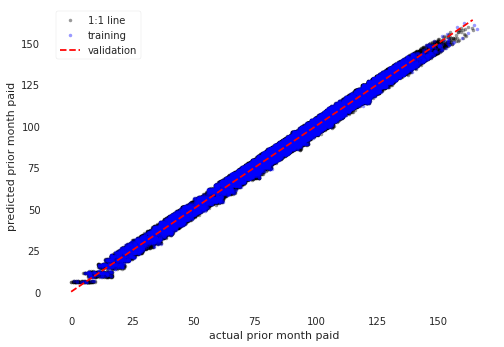

In [20]:
y_range = [train_y.min(), train_y.max()]
plt.plot(train_y, ridge.predict(train_x), '.k', alpha=0.4)
plt.plot(val_y, ridge.predict(val_x), '.b', alpha=0.4)
plt.plot(y_range, y_range, '--r')
plt.xlabel('actual prior month paid')
plt.ylabel('predicted prior month paid')
plt.legend(['1:1 line', 'training', 'validation'])

In [21]:
coefs = pd.Series(ridge.coef_, index=features)

In [22]:
coefs = coefs.sort_values(ascending=False)

<BarContainer object of 17 artists>

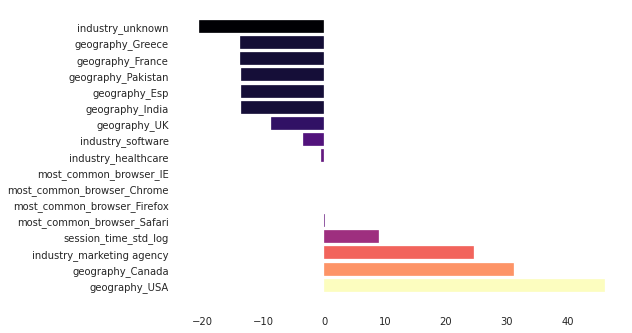

In [23]:
cmap = plt.get_cmap("magma")
norm = plt.Normalize(coefs.values.min(), coefs.values.max())
plt.barh(
    coefs.index, 
    coefs.values, 
    color=cmap(norm(coefs.values))
)

First we look at the positive side. The graph above and the pairplot below suggests that customers in USA and Canada in general pay more even for the same amount of session time. This is consistent with our observations in the raw data. Further more, more session time does lead to more money spent. We also see that marketing agency tend to spend much more than other industries when all else are equal. From these observations we suggest that:

- more focus on the USA and Canada markets and marketing agencies: those are where investments to improve user engagement provides the best return.
- investigate why we get less income from other countries. Especially UK given that the language is the same as USA and Canada. Could it be local culture or local law?
- obviously try to improve ways to make user engage with the software, the more time they spend tend to lead to more income for the Moz.

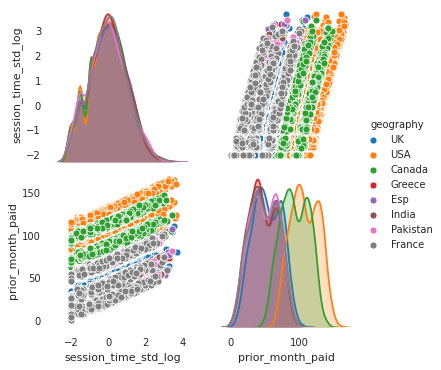

In [24]:
sns.pairplot(train_data[['session_time_std_log', target, 'geography']], hue='geography')

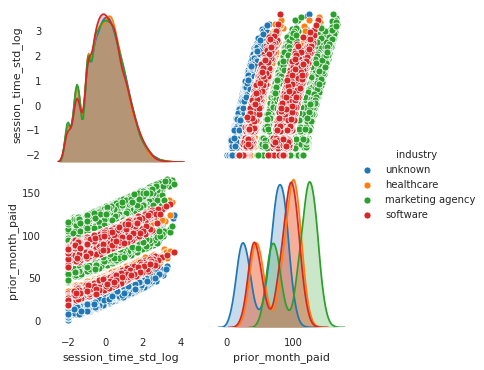

In [25]:
sns.pairplot(train_data[['session_time_std_log', target, 'industry']], hue='industry')

Now we investigate the negative side. The browser doesn't swing the needle after all as we were expecting. We see that markets in places other than Canada and US have strong negative impact: the customer in those regions tend to pay less when all things are equal. This is a different behavior compared to different industries, where other industry doesn't mean the customer will tend to pay significantly less than other indstries. If we can investigate more on the `unknown` industry we may be able to single out an industry that behaves differently from others but this is a low priority.

### Extra: Random Forest Model
Here I demonstrate the power of a tree based model. In this model we use the original session time feature, not log transformed or cutoff, or standardized. Random Forest model  work just with the order of features so the exact distribution doesn't affect the model's performance. We expect the random forest model to perform almost indentical to the highly engineered linear model above. The tradeoff is the training time: a Random Forest model can take minutes to 10s of minutes to train and tune.

In [26]:
features = [col for col in train_data_oh if col not in [
    target,'session_time_std_log', 
    'session_time_prior_month_seconds_log',
    'session_time_log_cutoff'
]]

train_x, train_y = train_data_oh[features], train_data_oh[target]
test_x, test_y = test_data_oh[features], test_data_oh[target]
train_x, val_x, train_y, val_y = train_test_split(
    train_x, train_y, test_size=0.2, random_state=42
)

In [27]:
param_distribtions = {
    'n_estimators': np.arange(100, 200, 50),
    'max_depth': np.arange(10, 50, 5),
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': ['auto', 3],
}

model = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_distribtions,
    verbose=1, random_state=42, n_jobs=-1, n_iter=20
)

In [28]:
model.fit(train_x, train_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45]),
                                        'max_features': ['auto', 3],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': array([100, 150])},
                   random_state=42, verbose=1)

In [29]:
print(f"training score is {model.score(train_x, train_y)}")
print(f"testing score is {model.score(val_x, val_y)}")

training score is 0.9946961414871061
testing score is 0.9910957487937969


Here to save time to didn't allow the tuning to do too many experiments and narrowed down the forest complexity by using lower number of estimators (i.e, trees in the forest). Generally for data of this size we can test up to 1000 estimators in a forest. Regardless the randon forest has a performance very close to the linear model, with potential room to improve more.

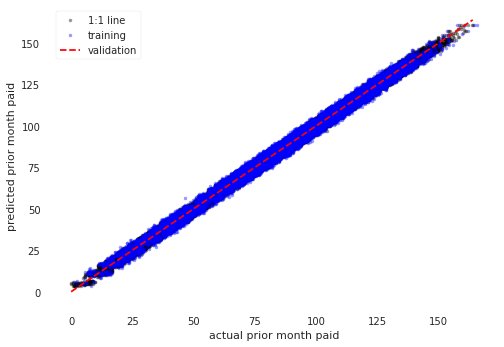

In [30]:
y_range = [train_y.min(), train_y.max()]
plt.plot(train_y, model.predict(train_x), '.k', alpha=0.4)
plt.plot(val_y, model.predict(val_x), '.b', alpha=0.4)
plt.plot(y_range, y_range, '--r')
plt.xlabel('actual prior month paid')
plt.ylabel('predicted prior month paid')
plt.legend(['1:1 line', 'training', 'validation'])

## model selection

Because the validation score for the ridge model is higher we choose the ridge model as the final model. Next, we use the trained model to evalute the test set to get the expected performance of the model then we retrain the model with all data to generate a model for deployment.

training score is 0.991744913295568
testing score is 0.9917543301712648


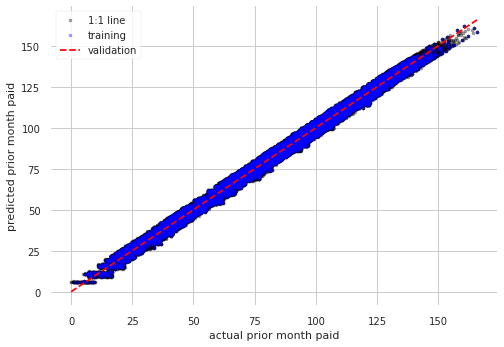

In [88]:
final_model = ridge

train_x, train_y = pd.concat([train_x, val_x]), pd.concat([train_y, val_y])
final_model.fit(train_x, train_y)

print(f"training score is {final_model.score(train_x, train_y)}")
print(f"testing score is {final_model.score(test_x, test_y)}")

y_range = [train_y.min(), train_y.max()]
plt.plot(train_y, final_model.predict(train_x), '.k', alpha=0.4)
plt.plot(val_y, final_model.predict(val_x), '.b', alpha=0.4)
plt.plot(y_range, y_range, '--r')
plt.xlabel('actual prior month paid')
plt.ylabel('predicted prior month paid')
plt.legend(['1:1 line', 'training', 'validation'])
plt.grid()
os.makedirs('figs', exist_ok=True)
plt.savefig('figs/model_performance.png', bbox_inches='tight')

We also make a few more figures for executive summary

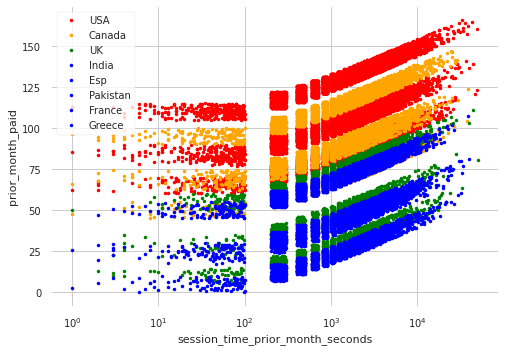

In [87]:
color_map = {
    'USA': 'red',
    'Canada': 'orange',
    'UK': 'green'
}
sorted_labels = [
    s[len('geography_'):] for s in coefs.index.tolist()
    if s.startswith('geography')
]
for label in sorted_labels:
    color = color_map.get(label, 'blue')
    group = train_data[train_data['geography']==label]
    plt.semilogx(
        group['session_time_prior_month_seconds'],
        group['prior_month_paid'],
        marker='.', color=color, linestyle='none',
        label=label
    )
plt.legend()
plt.grid()
plt.xlabel('session_time_prior_month_seconds')
plt.ylabel('prior_month_paid')
plt.savefig('figs/geography_impact.png', bbox_inches='tight')

In [80]:
sorted_labels = [
    s[len('industry_'):] for s in coefs.index.tolist()
    if s.startswith('industry')
]

In [81]:
sorted_labels

['marketing agency', 'healthcare', 'software', 'unknown']

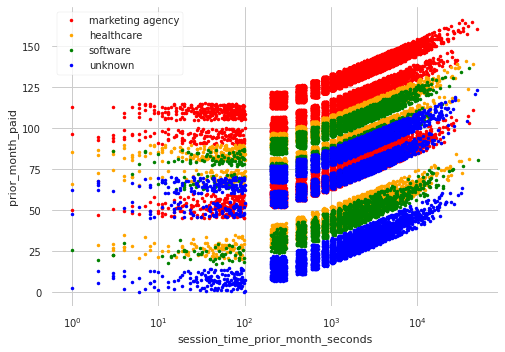

In [86]:
color_map = {
    'marketing agency': 'red',
    'healthcare': 'orange',
    'software': 'green',
    'unknow': 'blue'
}

for label in sorted_labels:
    color = color_map.get(label, 'blue')
    group = train_data[train_data['industry']==label]
    plt.semilogx(
        group['session_time_prior_month_seconds'],
        group['prior_month_paid'],
        marker='.', color=color, linestyle='none',
        label=label
    )
plt.legend()
plt.grid()
plt.xlabel('session_time_prior_month_seconds')
plt.ylabel('prior_month_paid')
plt.savefig('figs/industry_impact.png', bbox_inches='tight')

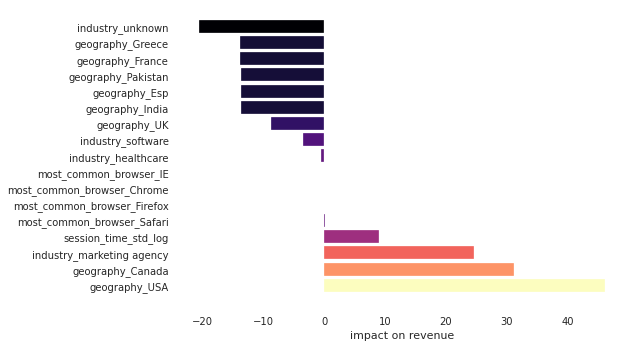

In [89]:
cmap = plt.get_cmap("magma")
norm = plt.Normalize(coefs.values.min(), coefs.values.max())
plt.barh(
    coefs.index, 
    coefs.values, 
    color=cmap(norm(coefs.values))
)
plt.xlabel('impact on revenue')
plt.savefig('figs/feature_slope.png', bbox_inches='tight')

In [90]:
import pickle

In [ ]:
final_model.fit(
    pd.concat([ttrai])
)

with open('model.pkl', 'rb') as fp:
    pickle(final_model)